In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/colbert-trained.zip

Archive:  gdrive/MyDrive/colbert-trained.zip
  inflating: colbert-trained/saved_model.pb  
  inflating: colbert-trained/variables.data-00000-of-00001  
  inflating: colbert-trained/variables.index  


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import load_model
import subprocess
from ast import literal_eval
model = load_model("colbert-trained/")

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 20)]         0           []                               
                                                                                       

In [ ]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: AMD EPYC 7B12
cpu MHz		: 2249.998
cpu cores	: 1
# RAM
MemTotal:       13302920 kB
# GPU

# OS
Linux da7f8d6966cd 5.4.144+ #1 SMP Tue Dec 7 09:58:10 PST 2021 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
pip install transformers sentencepiece

     |████████████████████████████████| 3.8 MB 13.9 MB/s 
     |████████████████████████████████| 1.2 MB 63.3 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 62.1 MB/s 
     |████████████████████████████████| 596 kB 70.0 MB/s 
     |████████████████████████████████| 6.5 MB 62.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras

import os
from scipy.stats import spearmanr
from math import floor, ceil
import transformers

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

2.8.0


In [ ]:
 #ified sampling. It performs this split by calling scikit-learn's function train_test_split() twice.

import pandas as pd
from sklearn.model_selection import train_test_split

df_input = pd.read_csv('/content/twitter-suicidal_data.csv')

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.8, frac_val=0.10, frac_test=0.10,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test =split_stratified_into_train_val_test(df_input, stratify_colname='intention', frac_train=0.80, frac_val=0.10, frac_test=0.10)

In [ ]:
df_train.shape

(7295, 2)

In [ ]:
df_val.shape


(912, 2)

In [ ]:
df_test.shape

(912, 2)

In [ ]:
training_sample_count = 7295 # 4000
test_count = 912

MAX_SENTENCE_LENGTH = 20
MAX_SENTENCES = 5
MAX_LENGTH = 100

In [ ]:

df_test.rename(columns={'tweet': 'text'}, inplace=True)
df_val.rename(columns={'tweet': 'text'}, inplace=True)
df_train.rename(columns={'tweet': 'text'}, inplace=True)


In [ ]:
test_df_y = df_test.copy()
#del df_test['intentions']

df_sub = test_df_y.copy()

print(len(df_input),len(df_train),len(df_test))
display(df_train.head())
display(df_test.head())

9119 7295 912


,text,intention
8713,funny how i m terrible for calling someone fat...,0
3386,d oh at least you re getting a decent exchang...,0
5232,back from 1st daii of term 2 i already miss sc...,0
8967,maybe he left because he saw me the way i see ...,1
1398,sucidal thoughts are on my mind so often hi ev...,1


,text,intention
3138,i dont even care about getting better i honest...,1
6793,iama mandarin chinese don t go 2 school don t ...,1
3897,im doing stupid english homework,0
4858,jus gettin up feelin dizzy from yesterdays dun...,0
7764,i hate reveluvs i hate them so much when i see...,0


In [ ]:
print(list(df_train.columns))

['text', 'intention']


In [ ]:
output_categories = list(df_train.columns[[1]])
input_categories = list(df_train.columns[[0]])

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['text']

output TARGET_COUNT:
	 1

output categories:
	 ['intention']


In [ ]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):
    model_input = []
    for xx in range((MAX_SENTENCES*3)+3):
        model_input.append([])

    for _, row in tqdm(df[columns].iterrows()):
        i = 0

        # sent
        sentences = sent_tokenize(row.text)
        for xx in range(MAX_SENTENCES):
            s = sentences[xx] if xx<len(sentences) else ''
            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH)
            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1

        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH)
        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)

    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)

    print(model_input[0].shape)
    return model_input



In [ ]:
import keras

In [ ]:
inputs = compute_input_arrays(df_train, input_categories, tokenizer)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer)

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(7295, 20)


0it [00:00, ?it/s]

(912, 20)


In [ ]:
print(len(inputs), len(inputs[0]), len(inputs[0][0]))

# check out input for 7th row
xx = 7
print(df_train.iloc[xx,0])
print(sent_tokenize(df_train.iloc[xx,0]))
inputs[0][xx], inputs[3][xx], inputs[6][xx], inputs[15][xx]

18 7295 20
i already hate the way it s coming out and i hate myself 
['i already hate the way it s coming out and i hate myself']


(array([ 101, 1045, 2525, 5223, 1996, 2126, 2009, 1055, 2746, 2041, 1998,
        1045, 5223, 2870,  102,    0,    0,    0,    0,    0], dtype=int32),
 array([101, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([101, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([ 101, 1045, 2525, 5223, 1996, 2126, 2009, 1055, 2746, 2041, 1998,
        1045, 5223, 2870,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [ ]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(df_train, output_categories)
#print(outputs.len)

In [ ]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))

        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)
        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)

mean_absolute_error  : 0.09999999999999999
mean_squared_error  : 0.009999999999999998
r2 score  : 0.96
f1_score  : 0.6666666666666666
[[0 1]
 [0 1]]
Acc 0.5 Prec 0.5 Rec 1.0 F1 0.6666666666666666


0.5

In [ ]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
#training data

In [ ]:
valid_inputs = inputs
valid_outputs = outputs

In [ ]:
model.fit(valid_inputs, valid_outputs, epochs=1, batch_size=24, verbose=1)

304/304 [==============================] - 10887s 36s/step - loss: 0.2402 - accuracy: 0.9105 - precision: 0.9215 - recall: 0.8699


In [ ]:
# testing data

In [ ]:
testing_outputs = compute_output_arrays(df_test, output_categories)
testing_inputs = test_inputs

In [ ]:
model.fit(testing_inputs, testing_outputs, epochs=1, batch_size=24, verbose=1)

38/38 [==============================] - 1423s 36s/step - loss: 0.1392 - accuracy: 0.9441 - precision: 0.9440 - recall: 0.9275


In [ ]:
preds = model.predict(testing_inputs)

In [ ]:
print(testing_outputs.shape, preds.shape)
print_evaluation_metrics(np.array(testing_outputs), np.array(preds), '')

(912, 1) (912, 1)
mean_absolute_error  : 0.01949108751458034
mean_squared_error  : 0.006552301076056702
r2 score  : 0.9733894672548647


0.006552301076056702

In [ ]:
testing_outputs_array = np.array(testing_outputs)
testing_preds = np.array(preds)

In [ ]:
r = sklearn.metrics.confusion_matrix(testing_outputs_array,testing_preds.round())
print(r)

[[510   2]
 [  3 397]]


In [ ]:
#valid data

In [ ]:
val_inputs = compute_input_arrays(df_val, input_categories, tokenizer)

0it [00:00, ?it/s]

(912, 20)


In [ ]:
validate_outputs = compute_output_arrays(df_val, output_categories)
validate_inputs = val_inputs

In [ ]:
model.fit(validate_inputs, validate_outputs, epochs=1, batch_size=24, verbose=1)

38/38 [==============================] - 1374s 36s/step - loss: 0.1766 - accuracy: 0.9320 - precision: 0.9289 - recall: 0.9150


In [ ]:
val_preds = model.predict(validate_inputs)

In [ ]:
print(validate_outputs.shape, val_preds.shape)
print_evaluation_metrics(np.array(validate_outputs), np.array(val_preds), '')

(912, 1) (912, 1)
mean_absolute_error  : 0.06004235700687818
mean_squared_error  : 0.022024866517896965
r2 score  : 0.910551510854191


0.022024866517896965

In [ ]:
validate_outputs_array = np.array(validate_outputs)
validate_preds = np.array(val_preds)

In [ ]:
r = sklearn.metrics.confusion_matrix(validate_outputs_array,validate_preds.round())
print(r)

[[510   2]
 [ 18 382]]


Text(33.0, 0.5, 'true')

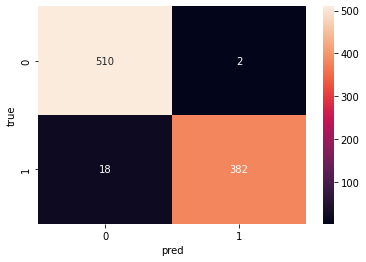

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(r, annot=True, fmt='d')
plt.xlabel('pred')
plt.ylabel('true')